# Table of Contents

1. Shape3D basics
2. [Sphere](#sphere)<br>
    - General position and velocity field<br>
    - Particles around/in a halo
3. [Box](#box)<br>
    - Full box slice<br>
    - Wrap the periodic boundary
4. [Cone](#cone)
5. [Cone Segment](#coneseg)

### This notebook shows how to use Shape3D objects and database functions to (quickly) selectively read Indra particles contained in geometric shapes.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import SciServer.CasJobs as cj
import pandas
import indratools as indra

In [2]:
boxlen = 1000.
hbox = boxlen/2
snapnum = 57
runnum = 440

# Shape3D Basics

The Shape3D object classes serve two functions. First, they define the `str` method to return a string that can be interpreted by the SQL Spatial3D library installed on the Indra database context. Second, they define the `contained` method that determines whether particles are within the given shape. All shapes can span the periodic boundaries of the simulation cube. Let's demonstrate on a cube with random points.

In [3]:
npart = 256**3
pos = np.random.rand(npart,3)*hbox # our random cube with length = hbox

In [4]:
center = [2, 30, 401]
radius = 10
shape = indra.Sphere(center[0],center[1],center[2],radius)
posinsphere = pos[shape.contained(pos,box=hbox)]

Since we have picked a sphere that crosses the box boundary along the x-axis, we should correct our positions for periodic boundary conditions.

In [5]:
posinsphere[(posinsphere - center) < -hbox/2] += hbox
posinsphere[(posinsphere - center) >= hbox/2] -= hbox

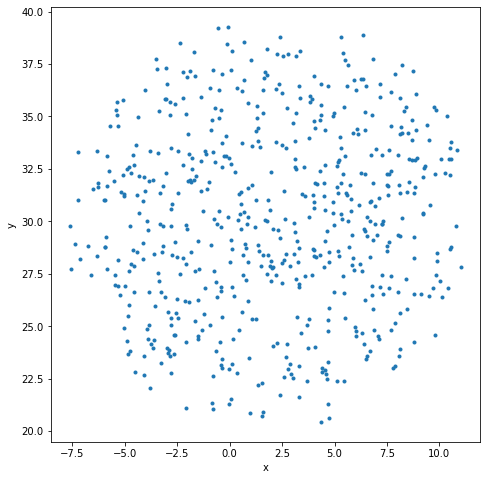

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(posinsphere[:,0],posinsphere[:,1],marker='.')
plt.gca().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y');

Particles within shapes can be selected from Indra simulations using the `indra.particlesInShape` function, which takes the same arguments as the main reading functions (`runid`,`snapnum`, and optional `datadir`, etc.) plus the shape object. Positions are always returned, and optionally the velocities and particle IDs can be returned by setting `getvel` or `getIDs` to True.

# Sphere
<a id="sphere"></a>

The arguments of the Sphere objects are: (cx, cy, cz, radius). Let's look at the positions and velocity field of particles in a random sphere.

In [3]:
shape = indra.Sphere(12,15,347,10)
%time pv = indra.particlesInShape(runnum,snapnum,shape,getvel=True)

CPU times: user 291 ms, sys: 261 ms, total: 552 ms
Wall time: 6.16 s


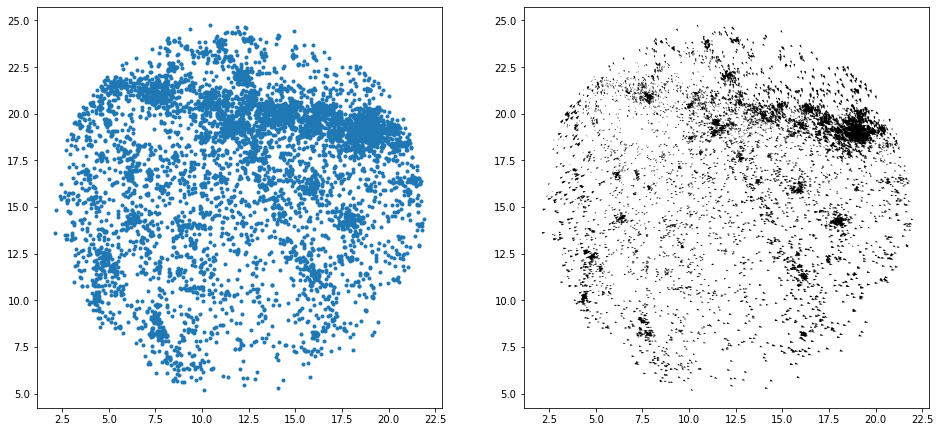

In [4]:
fig,axs = plt.subplots(1,2,figsize=(16,8))
axs[0].scatter(pv['x'],pv['y'],marker='.')
axs[0].set_aspect('equal')
axs[1].quiver(pv['x'],pv['y'],pv['vx'],pv['vy'])
axs[1].set_aspect('equal');

## Particles in/around a halo

First let's find a halo to look at. How about the biggest?

In [9]:
X, Y, Z = indra.get_xyz(runnum)
tablename_fof = f'FOF_{X}{Y}{Z}'
sql = f"""select top 1 fofid, np, numSubs, m_crit200*1.0e10 as mass, r_crit200 as radius, x, y, z from {tablename_fof}
    where snapnum = {snapnum}
    order by mass desc
"""
df = cj.executeQuery(sql,'Indra').loc[0] # Select from the Indra database, grab the only row

We can select the particles that make up this halo by first getting all particles in a sphere, let's say 3 times the radius of the halo, and grabbing the particle IDs.

In [10]:
shape = indra.Sphere(df['x'],df['y'],df['z'],3*df['radius'])
p = indra.particlesInShape(runnum,snapnum,shape,getIDs=True)

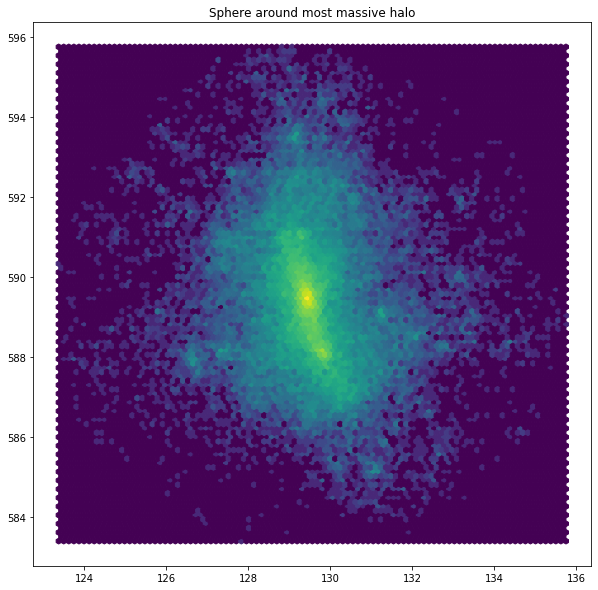

In [11]:
fig = plt.figure(figsize=(10,10))
plt.hexbin(p['x'],p['y'],bins='log')
plt.title('Sphere around most massive halo');

To get the particles that make up ONLY the halo, first we'll read all the IDs (see the `read_examples` notebook). Then we need to find the index of this halo that will correctly index the `groupids` (see the `database_examples` notebook). Unfortunately, we have to read the entire arrays for this snapshot, but at least we don't have to read all of the particles too!

In [12]:
groupLen,groupOffset,groupids = indra.getfofids(runnum,snapnum)

In [13]:
fofdf = cj.executeQuery(f'select fofid, np from {tablename_fof} where snapnum={snapnum} order by fofid','Indra')
cat = indra.getsubcat(runnum,snapnum)
hasSubs = np.where(cat['NsubPerHalo'] > 0)[0]

In [14]:
fofid = hasSubs[fofdf.index[fofdf['fofid'] == df['fofid']].values[0]]
haloIDs = groupids[groupOffset[fofid]:groupOffset[fofid]+groupLen[fofid]]

This is the parent FOF group for many subhalos. The number of particles listed in the database corresponds to the number in the main subhalo.

In [15]:
print(f"Parent FOF halo: {len(haloIDs)}, Main Subhalo: {cat['subLen'][cat['FirstSubOfHalo'][fofid]]}, Database: {df['np']}")

Parent FOF halo: 45443, Main Subhalo: 43494, Database: 43494.0


In [16]:
print(f"Particles in sphere: {p['NumParticles']}")

Particles in sphere: 54898


In [17]:
fofparticles = np.isin(p['ids'],haloIDs,assume_unique=True)

In [18]:
np.sum(fofparticles)

45443

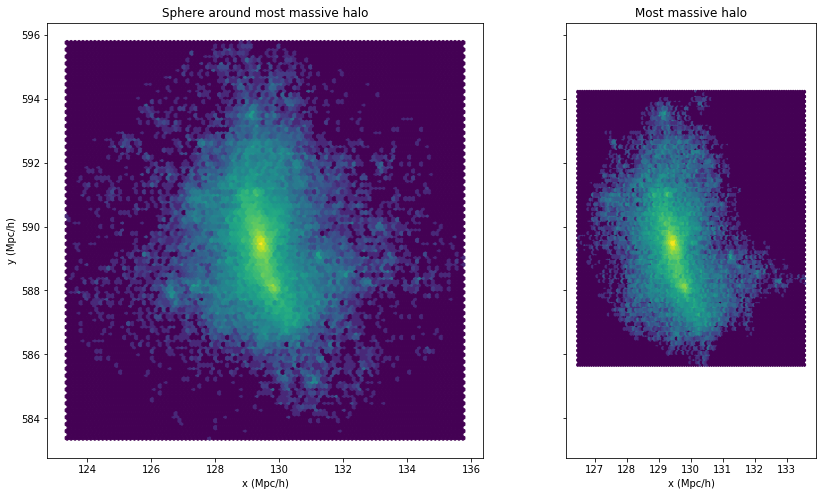

In [19]:
fig, axs = plt.subplots(ncols=2,sharey=True,subplot_kw=dict(aspect='equal'),figsize=(14,8),
    gridspec_kw=dict(width_ratios=[p['x'].max()-p['x'].min(),p['x'][fofparticles].max()-p['x'][fofparticles].min()]))
axs[0].hexbin(p['x'],p['y'],bins='log')
axs[0].set_xlabel('x (Mpc/h)')
axs[0].set_ylabel('y (Mpc/h)')
axs[0].set_title('Sphere around most massive halo');
axs[1].hexbin(p['x'][fofparticles],p['y'][fofparticles],bins='log')
axs[1].set_xlabel('x (Mpc/h)')
axs[1].set_title('Most massive halo');

# Box
<a id="box"></a>

The arguments of the Box objects are: (xmin, ymin, zmin, xmax, ymax, zmax). First let's select and plot a slice through the entire simulation cube.

In [20]:
shape = indra.Box(0,0,0,4,boxlen,boxlen)
%time p = indra.particlesInShape(runnum,snapnum,shape)

CPU times: user 54.2 s, sys: 21.8 s, total: 1min 16s
Wall time: 25.4 s


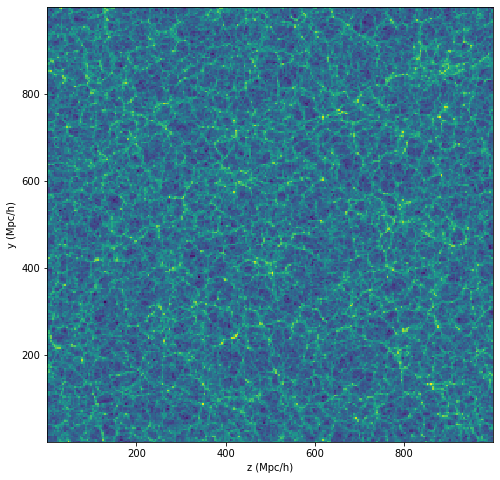

In [21]:
plt.figure(figsize=(8,8))
plt.hist2d(p['z'],p['y'],bins=256,norm=mpl.colors.LogNorm()); # this order matches the order returned by imshow for CIC density fields
plt.xlabel('z (Mpc/h)')
plt.ylabel('y (Mpc/h)');

In order to select a box that spans the periodic boundary, define the box in coordinates that wrap above or below the boundary.

In [22]:
shape = indra.Box(-10,995,598,4,1007,610)
p = indra.particlesInShape(runnum,snapnum,shape)
# same as above, cross at the other boundary
shape = indra.Box(-10,-5,598,4,7,610)
newp = indra.particlesInShape(runnum,snapnum,shape)

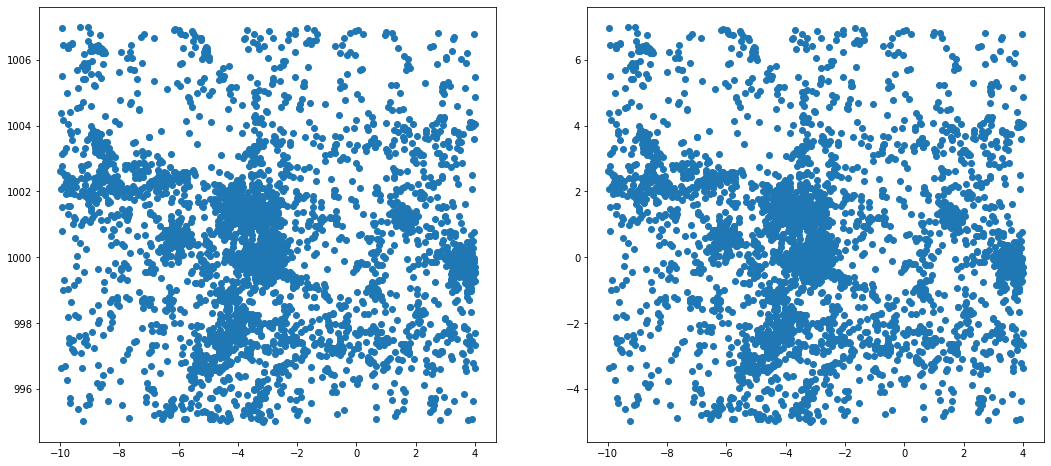

In [23]:
fig,axs = plt.subplots(1,2,figsize=(18,8))
axs[0].scatter(p['x'],p['y'])
axs[1].scatter(newp['x'],newp['y']);

# Cone
<a id="Cone"></a>

The arguments of the Cone objects are: 
- x, y, z: the origin/vertex of the cone
- dx, dy, dz: the direction vector
- angle: the (half) opening angle in radians
- depth: the depth of the cone

Like the other shapes, Cones can cross the periodic boundary. This is essential for constructing lightcones!

In [24]:
shape = indra.Cone(3,4,5,1.,2.,3.,np.pi/4,20)
p = indra.particlesInShape(runnum,snapnum,shape)

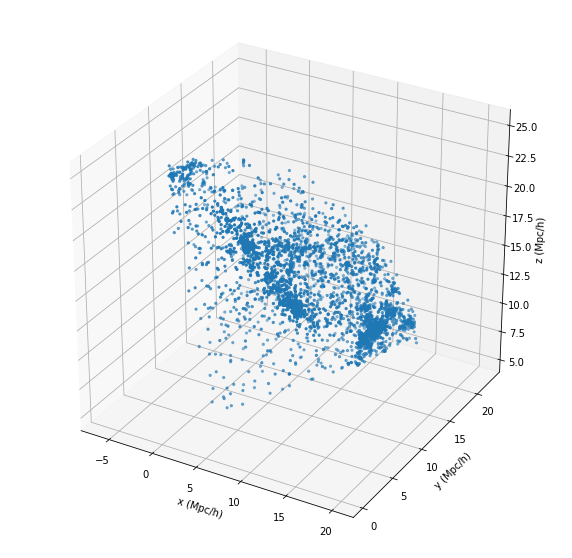

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(p['x'],p['y'],p['z'],marker='.')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)');

# Cone Segment
<a id="coneseg"></a>

The arguments of the ConeSegment objects are: 
- x, y, z: the origin/vertex of the cone
- dx, dy, dz: the direction vector
- angle: the (half) opening angle in radians
- depthmin, depthmax: the minimum and maximum depth of the cone segment


In [26]:
shape = indra.ConeSegment(3,4,5,1.,2.,3.,np.pi/20,75,100)
%time p = indra.particlesInShape(runnum,snapnum,shape)

CPU times: user 292 ms, sys: 126 ms, total: 418 ms
Wall time: 1.65 s


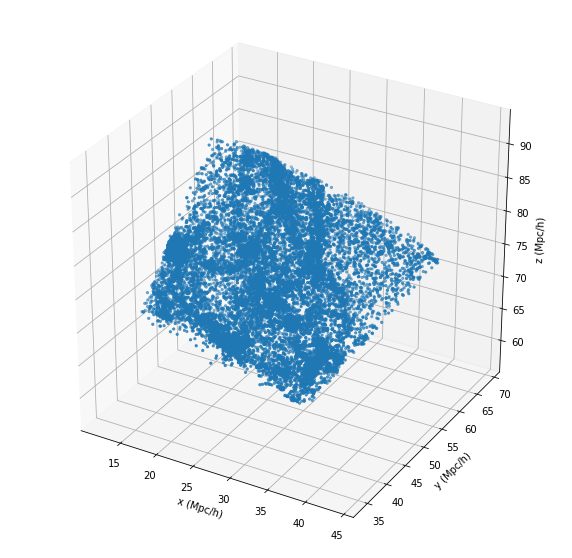

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(p['x'],p['y'],p['z'],marker='.')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)');

In [ ]:
# TO DO: proper lightcone with cosmology etc. First demonstrate on halos only in database_examples.